This notebook contains code to reproduce the multi-fidelity neural network function approximation results from Meng and Karniadakis 2019. 

In [28]:
''' Magics '''
%matplotlib notebook

''' Relevant imports '''
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import matplotlib 
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits import mplot3d

In [29]:
class MFNN(nn.Module):
    ''' Multi-fidelity neural network (Meng and Karniadakis 2019): 
        - nn_l: a neural network which generates predictions of the low-fidelity data
        - nn_h1: a neural network which computes linear correlation between the low- and high-fidelity data 
        - nn_h2: a neural network which computes nonlinear correlation between the low- and high-fidelity data '''
    def __init__(self, nn_l, nn_h1, nn_h2):
        super(MFNN, self).__init__()
        self.nn_l = nn_l 
        self.nn_h1 = nn_h1
        self.nn_h2 = nn_h2 

    def forward(self, x):
        # Compute low-fidelity prediction (y_l) via nn_l. 
        y_l = self.nn_l(x)
        # Compute linear and nonlinear correlations (F_l, F_nl) via nn_h1 and nn_h2. 
        F_l = self.nn_h1(torch.cat((x, y_l), 1))
        F_nl = self.nn_h2(torch.cat((x, y_l), 1))
        # Compute multi-fidelity prediction (h_1) from F_l and F_nl.
        y_h = F_l + F_nl
        return torch.cat((y_l, y_h), 1)

In [30]:
class FNN(nn.Module):
    '''Fully-connected neural network implementation (FNN): 
       - layer_sizes: the sizes of the layers from input to output layer 
       - activation: whether or not to use activation functions in this FNN. '''
    def __init__(self, layer_sizes, activation=True):
        super(FNN, self).__init__()
        # Create a list of linear layer modules of the specified sizes.  
        self.linear_layers = nn.ModuleList()
        self.activation = activation 
        for i in range(1, len(layer_sizes)): 
            self.linear_layers.append(nn.Linear(layer_sizes[i - 1], layer_sizes[i]))
            # Override default Lecun initialization to use Xavier's initialization method instead 
            nn.init.xavier_normal_(self.linear_layers[-1].weight)
    
    def forward(self, x):
        # Iterate through linear layers. 
        for linear_layer in self.linear_layers[:-1]: 
            # Apply activation to hidden layers if needed. 
            if self.activation: 
                x = torch.tanh(linear_layer(x))
            else: 
                x = linear_layer(x)
        # Don't use activation for last layer. 
        x = self.linear_layers[-1](x)
        return x

In [271]:
def train_MFNN(module, num_epochs, lr, l2_lambda, train_data, num_low, num_high, grad_low_fi=None, verbose=False): 
    ''' Runs end-to-end training for multi-fidelity neural network.'''
    
    # Set up optimizer. 
    optimizer = optim.LBFGS(module.parameters(), lr=lr)
    
    # Store inputs and targets, and gradients of low-fidelity function if available. 
    (inputs, targets) = (torch.narrow(train_data, 1, 0, 1), torch.narrow(train_data, 1, 1, 1))
    inputs.requires_grad = True 
    if grad_low_fi: 
        GT_l = grad_low_fi(inputs[:][:num_low])
    
    # Vairable to keep track of loss during training. 
    losses = []

    # Define the loss criterion. 
    def loss_MFNN(preds, targets, inputs):
        '''MSE loss calculation as specified in Meng and Karniadakis 2019'''
        
        # For low-fidelity train data, use low-fidelity prediction from nn_l. For high-fidelity train data,
        # use high-fidelity prediction from nn_h1 and nn_h2.
        Y_l = torch.narrow(torch.narrow(preds, 0, 0, num_low), 1, 0, 1)
        Y_h = torch.narrow(torch.narrow(preds, 0, num_low, num_high), 1, 1, 1)
        T_l, T_h = targets[:num_low], targets[num_low:]
        

#         Y_lg = module.nn_l(inputs)
        GY_l = torch.empty(size=(num_low, 1))
        for i in range(num_low): 
            x = inputs[:][i]
            y = module.nn_l(x)
            gyl = torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y), retain_graph=True)[0]
            GY_l[i] = gyl
#         GY_l = torch.autograd.grad(Y_lg, inputs, grad_outputs=torch.ones_like(Y_lg), retain_graph=True)[0]
#         x1 = torch.narrow(inputs, 0, 0, 1)
#         y1 = module.nn_l(x1)
#         print(y1)
#         g = torch.autograd.grad(y1, x1, grad_outputs=torch.ones_like(y1), retain_graph=True)[0].data
#         print("gradient")
#         print(g)
        

        # Compute MSE terms from low_fidelity and high-fidelity contribution.
        if grad_low_fi: 
            MSE_l = torch.mean((Y_l - T_l)**2 + (GY_l[:][:num_low] - GT_l)**2)
        else: 
            MSE_l = torch.mean((Y_l - T_l)**2)
        MSE_h = torch.mean((Y_h - T_h)**2)  
        
        # Compute L2 regularization term from nn_l and nn_h2 parameters. Only penalize for size of weights 
        # (not biases). 
        l2_reg = torch.tensor(0., requires_grad=True)
#         for (name, param) in module.nn_l.named_parameters():
#             if 'weight' in name: 
#                 l2_reg = l2_reg + torch.norm(param)**2
        for (name, param) in module.nn_h2.named_parameters(): 
            if 'weight' in name: 
                l2_reg = l2_reg + torch.norm(param)**2
        
        # Compute and return loss. 
        loss = MSE_l + MSE_h + l2_lambda * l2_reg 
        return loss
    
    # Define the closure to update weights in each epoch. 
    def closure(): 
        optimizer.zero_grad()
        preds = module(inputs)
        loss = loss_MFNN(preds, targets, inputs)
        losses.append(loss.item())
        loss.backward(retain_graph = True)
        return loss 
    
    # Loop for specified number of epochs. 
    for epoch in tqdm(range(num_epochs)): 
        optimizer.step(closure)
        if verbose and epoch % 100 == 0:
            print(module(inputs))
    
    return losses
        

In [288]:
def setup_training(low_fi, high_fi, nn_l_layers, nn_h1_layers, nn_h2_layers, low_pts, high_pts): 
    
    # Format train data. 
    inputs = torch.transpose(torch.tensor([low_pts+high_pts]), 0, 1)
    num_low = len(low_pts)
    num_high = len(high_pts)
    low = low_fi(inputs[:][:num_low])
    high = high_fi(inputs[:][num_low:])
    train_data = torch.cat((inputs, torch.cat((low, high))), 1)

    # Initialize model.
    if nn_l_layers: 
        nn_l = FNN(nn_l_layers)
    if nn_h1_layers: 
        nn_h1 = FNN(nn_h1_layers, activation=False)         # no activations for NN_H1 
    if nn_h2_layers: 
        nn_h2 = FNN(nn_h2_layers)
    nn_mfl = MFNN(nn_l, nn_h1, nn_h2)
    
    # Return parms for training. 
    return (nn_mfl, train_data, num_low, num_high)


In [295]:
def low_fi(x, A=.5, B=10, C=-5): 
    return A*(6*x-2)**2 * torch.sin(12*x-4) + B*(x-0.5) + C

def high_fi(x, A=.5, B=10, C=-5): 
    return (6*x-2)**2 * torch.sin(12*x-4)

def grad_low_fi(x, A=.5, B=10, C=-5): 
    return 6*torch.sin(12*x-4) + (72*x - 24)*torch.cos(12*x-4) + 10

# Setup training data.
(nn_mfl, train_data, num_low, num_high) = setup_training(
    low_fi, 
    high_fi, 
    [1, 20, 20, 1], 
    [2, 1], 
    [2, 10, 10, 1], 
    [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 
    [0, 0.4, 0.6, 1]
)

# Define training parameters and run training loop.
num_epochs = 8000
lr = .001
l2_lambda = .1
losses = train_MFNN(
    nn_mfl, 
    num_epochs, 
    lr, 
    l2_lambda, 
    train_data, 
    num_low, 
    num_high, 
    grad_low_fi=grad_low_fi
)

100%|██████████| 8000/8000 [04:03<00:00, 32.88it/s]


In [292]:
# WORKING

def low_fi(x, A=.5, B=10, C=-5): 
    return A*(6*x-2)**2 * torch.sin(12*x-4) + B*(x-0.5) + C

def high_fi(x, A=.5, B=10, C=-5): 
    return (6*x-2)**2 * torch.sin(12*x-4)

def grad_low_fi(x, A=.5, B=10, C=-5): 
    return 6*torch.sin(12*x-4) + (72*x - 24)*torch.cos(12*x-4) + 10

# Setup training data.
inputs = torch.transpose(torch.tensor([[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 0, 0.4, 0.6, 1]]), 0, 1)
num_low = 11
num_high = 4
low = low_fi(inputs[:][:num_low])
high = high_fi(inputs[:][num_low:])
train_data = torch.cat((inputs, torch.cat((low, high))), 1)

# Initialize model.
nn_l = FNN([1, 20, 20, 1])                      # 2 hidden layers with 20 neurons per layer 
nn_h1 = FNN([2, 1], activation = False)         # no hidden layers 
nn_h2 = FNN([2, 10, 10, 1])                     # 2 hidden layers with 10 neurons per layer
nn_mfl = MFNN(nn_l, nn_h1, nn_h2)

# Define training parameters.
num_epochs = 8000
lr = .001
l2_lambda = .1

# Run training loop.
losses = train_MFNN(nn_mfl, num_epochs, lr, l2_lambda, train_data, num_low, num_high, grad_low_fi=grad_low_fi)

  2%|▏         | 151/8000 [00:17<14:56,  8.76it/s]


KeyboardInterrupt: 

In [296]:
'''Generates plots for a given experiment. Provide: 
   - nn_mfl: the (trained) model 
   - train_data: the training data used  
   - num_low: number of low_fidelity data points used 
   - high_fi: a function to compute exact high-fidelity function value, given x
   - low_fi: a function to compute exact low-fidelity function value, given x
   - mesh_size (optional): how fine a mesh to use for plotting the exact and approximate functions. 
'''
def generate_plots(nn_mfl, train_data, num_low, high_fi, low_fi, mesh_size=1000): 
    
    plt.subplots(figsize=(8,8))
    
    '''Plot the data (a) in paper. Plots training data as well as exact low- and high-fidelity functions.'''
    ax1 = plt.subplot(2, 2, 1)
    x_test = torch.linspace(0, 1, mesh_size).view(mesh_size, 1)
    y_l = low_fi(x_test)
    y_h = high_fi(x_test)
    ax1.plot(x_test, y_h, 'k', linewidth=2)
    ax1.plot(x_test, y_l, 'grey', linewidth=2)
    inputs = torch.narrow(train_data, 1, 0, 1)
    ax1.plot(inputs[:][:num_low], low, 'bo', linewidth=5, markersize=8)
    ax1.plot(inputs[:][num_low:], high, 'rx', linewidth=5, markersize=8, mew=2)
    ax1.set_xlabel("x")

    '''Plot the approximation (c) in paper. Plots exact and approximate low- and high-fidelity functions.'''
    ax2 = plt.subplot(2, 2, 2)
    preds = nn_mfl(x_test)
    x_test = torch.linspace(0, 1, mesh_size).view(mesh_size, 1)
    ax2.plot(x_test, y_h, 'k', linewidth=2)
    ax2.plot(x_test, y_l, 'grey', linewidth=2)
    ax2.plot(x_test, torch.narrow(preds, 1, 0, 1).detach().numpy(), 'b--', linewidth=2)
    ax2.plot(x_test, torch.narrow(preds, 1, 1, 1).detach().numpy(), 'r--', linewidth=2)
    ax2.set_xlabel("x")

    '''Plot the correlations (d) in paper'''
    ax3 = plt.subplot(2, 2, 3, projection='3d')
    ax3.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax3.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax3.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax3.grid(False)
    ax3.plot(
        y_h.view(mesh_size).numpy(),
        y_l.view(mesh_size).numpy(), 
        x_test.view(mesh_size).numpy(),
        'k', 
        linewidth=2
    )
    ax3.plot(
        torch.narrow(preds, 1, 1, 1).detach().view(mesh_size).numpy(),
        torch.narrow(preds, 1, 0, 1).detach().view(mesh_size).numpy(), 
        x_test.view(mesh_size).numpy(),
        'r--',
        linewidth=2
    )
    ax3.plot(
        y_h.view(mesh_size).numpy(),
        y_l.view(mesh_size).numpy(), 
        np.zeros(mesh_size),
        'grey',
        linewidth=2
    )
    ax3.plot(
        torch.narrow(preds, 1, 1, 1).detach().view(mesh_size).numpy(),
        torch.narrow(preds, 1, 0, 1).detach().view(mesh_size).numpy(), 
        np.zeros(mesh_size),
        'b--',
        linewidth=2
    )
    ax3.set_xlabel("y_h")
    ax3.set_xlim(20, -20)  
    ax3.set_ylabel("y_l")
    ax3.set_ylim(-10, 10) 
    ax3.set_zlabel("x")
    ax3.set_zlim(0, 1)

<IPython.core.display.Javascript object>


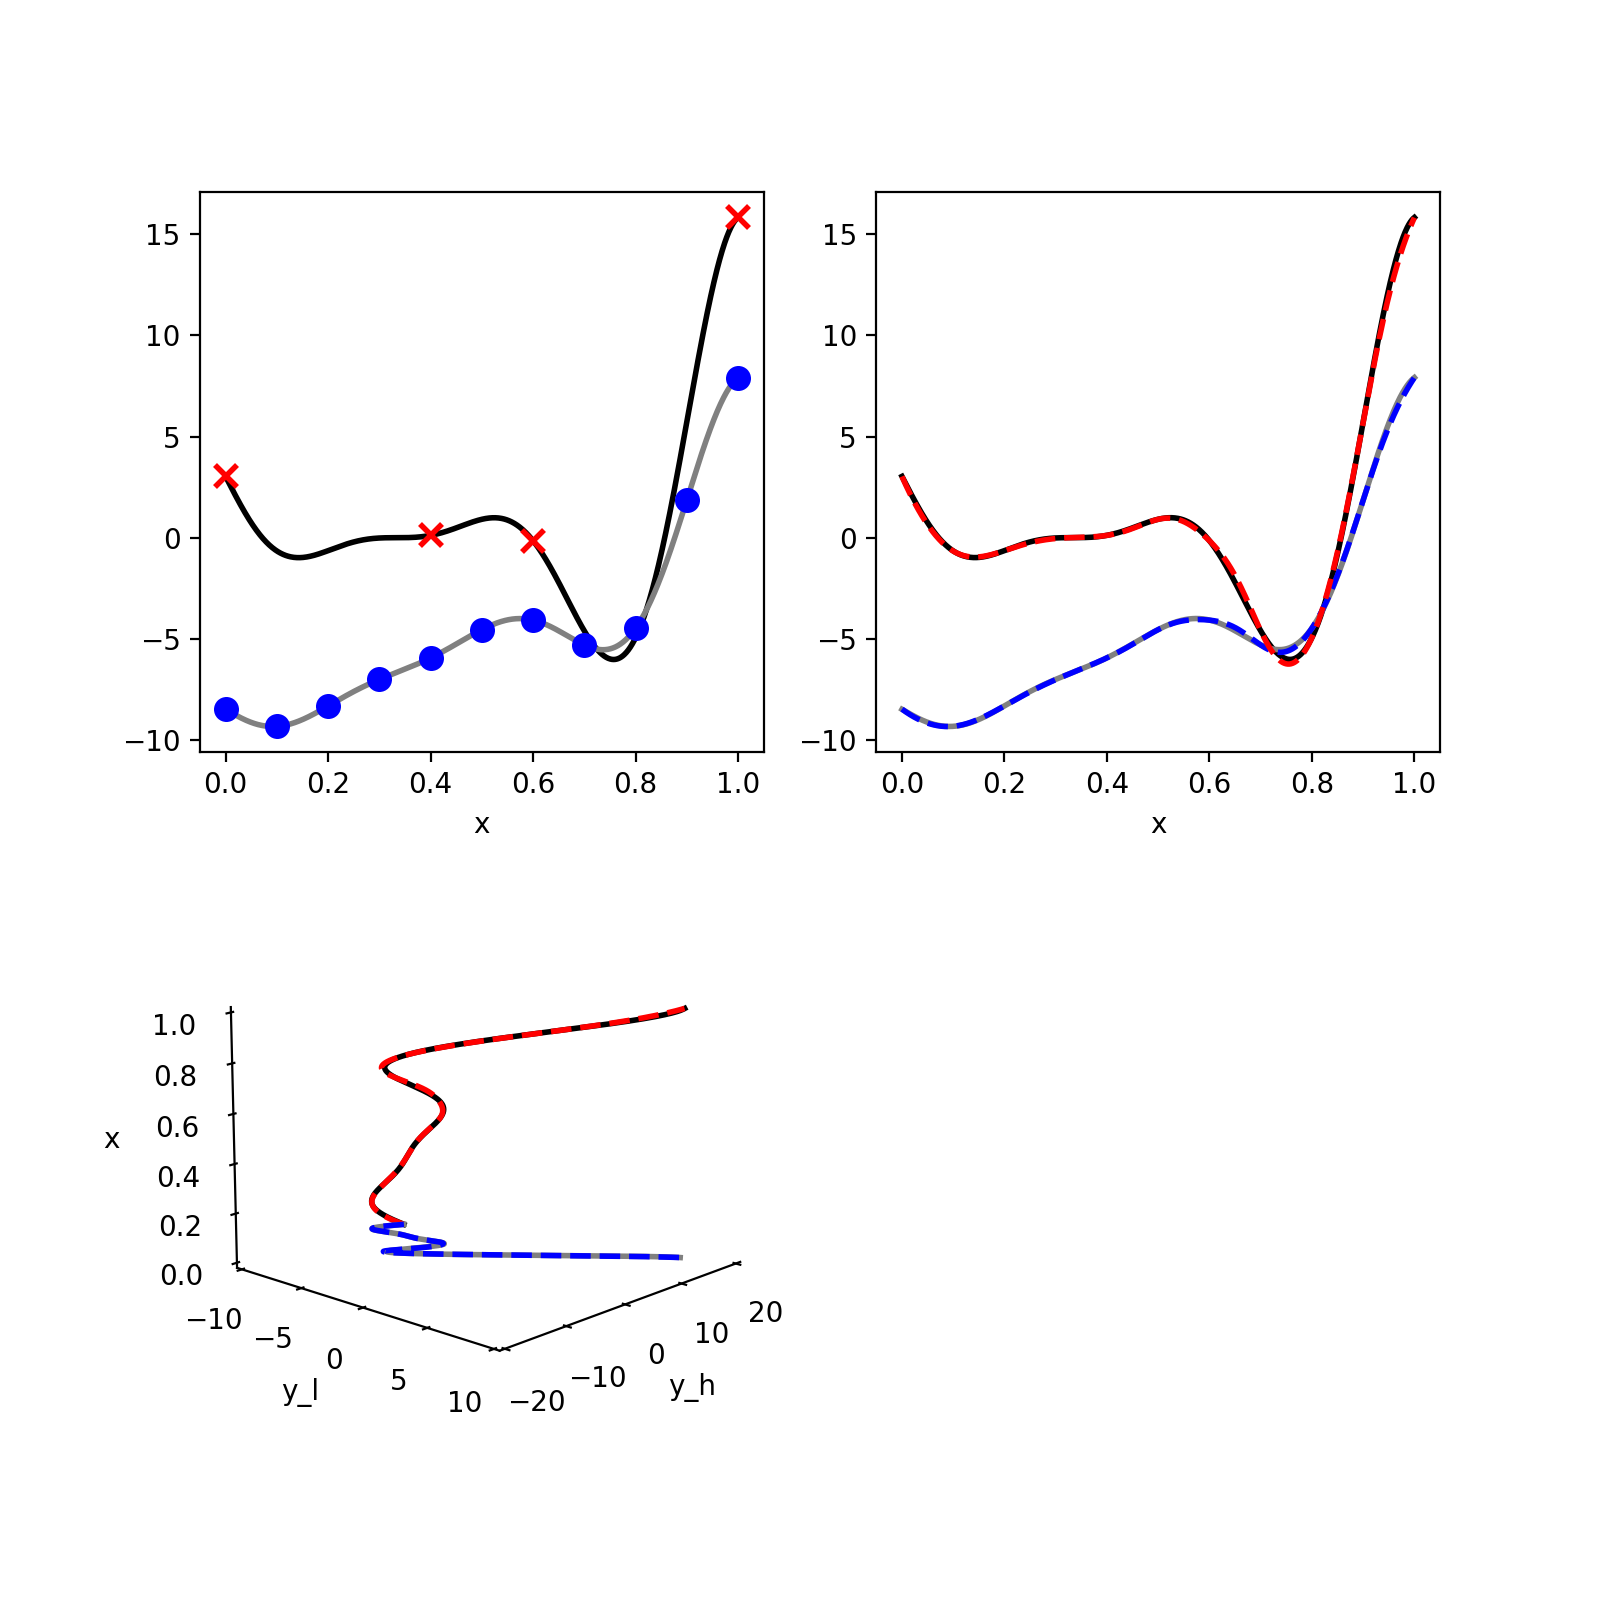

In [294]:
generate_plots(nn_mfl, train_data, num_low, high_fi, low_fi, mesh_size=1000)

In [218]:
inputs.shape

torch.Size([15, 1])

In [223]:
preds

tensor([[nan, nan],
        [nan, nan],
        [nan, nan],
        ...,
        [nan, nan],
        [nan, nan],
        [nan, nan]], grad_fn=<CatBackward>)

In [99]:
nn_l = FNN([10, 1])
nn_h1 = FNN([11, 11, 1])
nn_h2 = FNN([11, 11, 1])
nn_mfl = MFNN(nn_l, nn_h1, nn_h2)
x1 = torch.randn(1, 10)
x2 = torch.randn(1, 10)
x = torch.cat((x1, x2), 0)
output = nn_mfl(x)

In [30]:
output[:, 1]


tensor([-1.1282, -3.7975], grad_fn=<SelectBackward>)

In [44]:
x1[0][:3]

tensor([-1.2471,  2.1380, -1.0021])

In [55]:
for (name, param) in nn_h2.named_parameters(): 
    print(name)

linear_layers.0.weight
linear_layers.0.bias
linear_layers.1.weight
linear_layers.1.bias


In [56]:
l2_reg = torch.tensor(0., requires_grad=True)

In [123]:
str(2, 3.4)

TypeError: str() argument 2 must be str, not float

In [217]:
x = torch.empty(size=(768, 1))
for i in range(768):
    x[i] = i
x

tensor([[  0.],
        [  1.],
        [  2.],
        [  3.],
        [  4.],
        [  5.],
        [  6.],
        [  7.],
        [  8.],
        [  9.],
        [ 10.],
        [ 11.],
        [ 12.],
        [ 13.],
        [ 14.],
        [ 15.],
        [ 16.],
        [ 17.],
        [ 18.],
        [ 19.],
        [ 20.],
        [ 21.],
        [ 22.],
        [ 23.],
        [ 24.],
        [ 25.],
        [ 26.],
        [ 27.],
        [ 28.],
        [ 29.],
        [ 30.],
        [ 31.],
        [ 32.],
        [ 33.],
        [ 34.],
        [ 35.],
        [ 36.],
        [ 37.],
        [ 38.],
        [ 39.],
        [ 40.],
        [ 41.],
        [ 42.],
        [ 43.],
        [ 44.],
        [ 45.],
        [ 46.],
        [ 47.],
        [ 48.],
        [ 49.],
        [ 50.],
        [ 51.],
        [ 52.],
        [ 53.],
        [ 54.],
        [ 55.],
        [ 56.],
        [ 57.],
        [ 58.],
        [ 59.],
        [ 60.],
        [ 61.],
        

In [276]:
a = [1, 2, 3]
a.extend([4, 5, 6])

In [277]:
a

[1, 2, 3, 4, 5, 6]